In [351]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from tqdm.auto import trange

In [352]:
!pip install navec
from navec import Navec

path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [353]:
train_data = pd.read_csv('validation_data_labeled.csv', sep='\t')
sentences = train_data.sentence
emb = np.zeros((len(sentences), 100))
'''
for i in range(len(sentences)):
    sentence = sentences[i].split(" ")
    for j in range(len(sentence)):
        if sentence[j] in navec:
            emb[i][j] = navec[sentence[j]]
'''
a = [0]
for i in range(len(sentences)):
    sentence = sentences[i].split(" ")
    for j in range(len(sentence)):
        a.append(sentence[j])
        emb[i][j] = len(a) - 1

In [354]:
X = emb
y = pd.DataFrame(train_data['label'])
y.replace(1, 2, inplace=True)
y.replace(0, 1, inplace=True)
y.replace(-1, 0, inplace=True)
y = np.array(y)

In [355]:
y

array([[1],
       [1],
       [1],
       ...,
       [0],
       [1],
       [1]])

In [356]:
X.shape

(2845, 100)

In [357]:
y.shape

(2845, 1)

In [358]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [359]:
X_train

array([[28074., 28075., 28076., ...,     0.,     0.,     0.],
       [36072., 36073., 36074., ...,     0.,     0.,     0.],
       [ 3341.,  3342.,  3343., ...,     0.,     0.,     0.],
       ...,
       [22826., 22827., 22828., ...,     0.,     0.,     0.],
       [26162., 26163., 26164., ...,     0.,     0.,     0.],
       [17518., 17519., 17520., ...,     0.,     0.,     0.]])

In [360]:
X_val

array([[ 8481.,  8482.,  8483., ...,     0.,     0.,     0.],
       [45223., 45224., 45225., ...,     0.,     0.,     0.],
       [23190., 23191., 23192., ...,     0.,     0.,     0.],
       ...,
       [31963., 31964., 31965., ...,     0.,     0.,     0.],
       [ 8905.,  8906.,  8907., ...,     0.,     0.,     0.],
       [40331., 40332., 40333., ...,     0.,     0.,     0.]])

In [361]:
y_train

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [362]:
y_val

array([[2],
       [2],
       [1],
       [0],
       [2],
       [1],
       [1],
       [2],
       [1],
       [1],
       [0],
       [2],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
    

In [363]:
xt = np.zeros((len(X_train), 100, 300))
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        if X_train[i][j] != 0:
            if a[int(X_train[i][j])] in navec:
                xt[i][j] = navec[a[int(X_train[i][j])]]
X_train = xt

In [364]:
xt = np.zeros((len(X_val), 100, 300))
for i in range(len(X_val)):
    for j in range(len(X_val[i])):
        if X_val[i][j] != 0:
            if len(a) <= int(X_val[i][j]):
                print(int(X_val[i][j]))
            if a[int(X_val[i][j])] in navec:
                xt[i][j] = navec[a[int(X_val[i][j])]]
X_val = xt

In [365]:
def df_to_tensor(df):
    return torch.from_numpy(df.values).float()

In [366]:
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_val_t = torch.from_numpy(X_val)
y_val_t = torch.from_numpy(y_val)
X_train_t = torch.permute(X_train_t, (0, 2, 1))
X_val_t = torch.permute(X_val_t, (0, 2, 1))

In [367]:
'''
y_train_t = y_train_t.type(torch.DoubleTensor)
y_val_t = y_val_t.type(torch.DoubleTensor)
'''

'\ny_train_t = y_train_t.type(torch.DoubleTensor)\ny_val_t = y_val_t.type(torch.DoubleTensor)\n'

In [368]:
y_train_t

tensor([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]])

In [369]:
X_val_t

tensor([[[ 0.0000,  0.3146,  0.0482,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.1777, -0.2004,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.2426,  0.0586,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000, -0.2754,  0.2750,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0252,  0.2647,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.3528,  0.4108,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.2733,  0.0574,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0049, -0.6995,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0492,  0.5508,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000, -0.5250, -0.4420,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.1350, -0.1768,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.2226,  0.5108,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000, -0.4161, -0.5378,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.8234, -0.6289,  ...,  0

In [370]:
y_train_t.dtype

torch.int64

In [371]:
y_val_t.dtype

torch.int64

In [372]:
X_val_t.dtype

torch.float64

In [373]:
X_train_t.dtype

torch.float64

In [374]:
print(X_train_t.shape)
print(X_val_t.shape)

torch.Size([2133, 300, 100])
torch.Size([712, 300, 100])


In [375]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)


In [376]:
def fit(epochs, model_, loss_func, opt, train_dl, valid_dl, lr_sched=None):
    model_ = model_.to(device)
    train_losses = []
    val_losses = []
    valid_accuracies = []
    pbar = trange(epochs, desc="Epoch:")
    for epoch in pbar:
        model_.train()
        loss_sum = 0

        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            probs = model_(xb.float())
            loss = loss_func(probs, yb)
            loss_sum += loss.item()
            loss.backward()

            opt.step()
            opt.zero_grad()

        train_losses.append(loss_sum / len(train_dl))


        model_.eval()
        loss_sum = 0
        correct = 0
        num = 0

        with torch.no_grad():
            for xb, yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                probs = model_(xb.float())

                loss = loss_func(probs, yb)
                loss_sum += loss.item()

                _, pred = torch.max(probs, axis=-1)
                correct += (pred == yb).sum().item()
                num += len(xb)


        val_loss = loss_sum / len(valid_dl)
        val_acc = correct / num
        val_losses.append(val_loss)
        valid_accuracies.append(val_acc)

        pbar.set_description('Epoch: {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, val_loss, val_acc))

        #torch.save(model.state_dict(), PATH)   #сохранение весов модели на будущее

        if lr_sched is not None:
            lr_sched.step()

    return train_losses, val_losses, valid_accuracies

Load Model:
    model = TheModelClass(*args, **kwargs)
    model.load_state_dict(torch.load(PATH))
    model.eval()

In [377]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self):
        super(MultiLayerPerceptron, self).__init__()
        # Embedding size, Hyperparameter, Output
        self.conv1 = nn.Conv1d(in_channels=300, out_channels=300, kernel_size=5) #96
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2) #48
        self.conv2 = nn.Conv1d(in_channels=300, out_channels=300, kernel_size=5) #44
        #22
        self.conv3 = nn.Conv1d(in_channels=300, out_channels=300, kernel_size=5) #18
        #9
        self.conv4 = nn.Conv1d(in_channels=300, out_channels=300, kernel_size=2) #8
        #4
        self.conv5 = nn.Conv1d(in_channels=300, out_channels=300, kernel_size=3) #2
        #1
        self.fc1 = nn.Linear(1, 4096)
        self.fc2 = nn.Linear(4096, 1)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.pool(F.leaky_relu(self.conv4(x)))
        x = self.pool(F.leaky_relu(self.conv5(x)))
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

In [378]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [379]:
model = MultiLayerPerceptron().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)

info = fit(64, model, criterion, optimizer, train_dataloader, val_dataloader, scheduler)

Epoch::   0%|          | 0/64 [00:00<?, ?it/s]

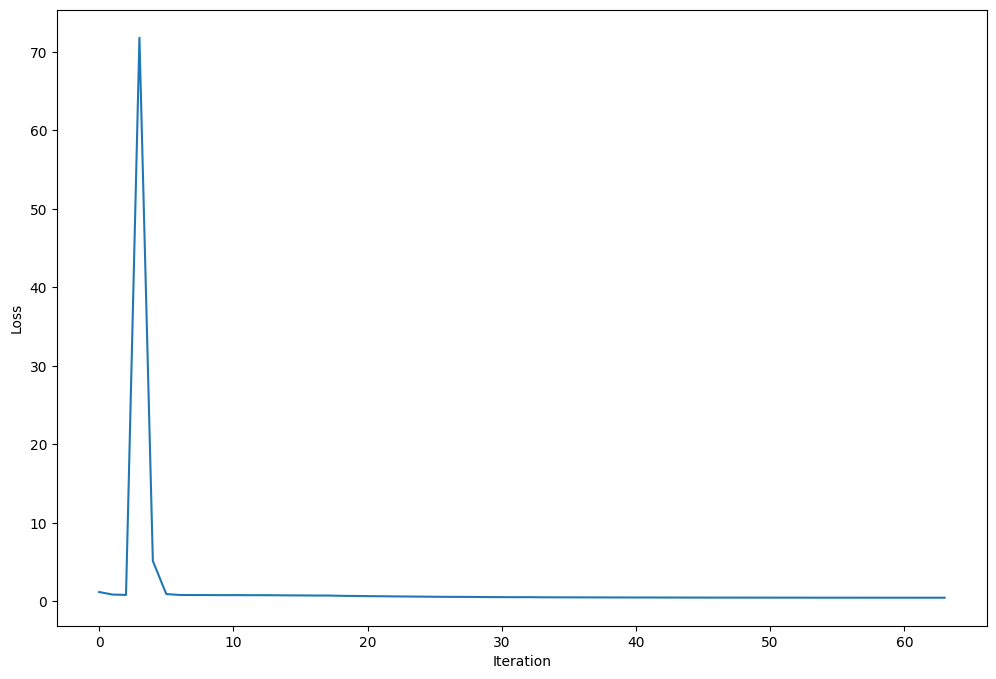

In [380]:
train_losses = info[0]
plt.figure(figsize=(12, 8))
plt.plot(range(len(train_losses)), train_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [382]:
import sys
sys.path.append('../..')

from sklearn import metrics as multi_metrics

In [384]:
model.eval()
xb, yb = next(iter(val_dataloader))
probs = model(xb.float())
_, pred = torch.max(probs, axis=-1)

In [385]:
multi_metrics.f1_score(y_true=yb, y_pred=pred, average='macro')

ValueError: ignored

In [396]:
probs

tensor([[[   60.4230],
         [   65.3831],
         [   56.0567],
         ...,
         [ -785.8742],
         [ -532.0670],
         [ -442.3941]],

        [[   54.7043],
         [   56.4982],
         [   54.5911],
         ...,
         [ -945.2944],
         [ -541.6350],
         [ -509.9999]],

        [[   54.7043],
         [   56.4982],
         [   54.5911],
         ...,
         [ -325.6674],
         [ -227.9635],
         [ -164.9787]],

        ...,

        [[   91.6780],
         [   82.5374],
         [   68.2778],
         ...,
         [-1629.0583],
         [-1392.5046],
         [-1075.9264]],

        [[   61.3859],
         [   68.2846],
         [   56.1786],
         ...,
         [-1283.0623],
         [ -895.9270],
         [ -790.5251]],

        [[   54.7043],
         [   56.4982],
         [   54.5911],
         ...,
         [ -638.0828],
         [ -510.4298],
         [ -399.4659]]], grad_fn=<LeakyReluBackward0>)